<div style="padding:15px 20px 20px 20px;
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">
<p style="font-weight: bold; text-align: center;">Поиск по изображениям</p>

</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ Хостинг для профессиональных фотографов «With Sense».
    
__Описание задачи:__ Фотографы размещают фотографии и сопровождают их описанием. Дополнить описание могут и другие пользователь сервиса.


__Постановка задачи:__ Разработать демонстрационную версию поиска изображений по запросу.
    
__Описание данных:__
    
- файл `train_dataset.csv` содержит информацию, необходимую для обучения:
    - имя файла изображения;
    - идентификатор описания в формате: <имя файла изображения>#<порядковый номер описания>;
    - текст описания (доступно до 5 описаний)
    
- директория `/train_images/` содержит изображения для тренировки моделей.
    
- файл `CrowdAnnotations.tsv` включает данные по соответствию изображения и описания, полученные с помощью краудсорсинга:
    - имя файла изображения;
    - идентификатор описания;
    - доля людей, подтвердивших, что описание соответствует изображению;
    - количество человек, подтвердивших, что описание соответствует изображению;
    - количество человек, подтвердивших, что описание не соответствует изображению.

- файл `ExpertAnnotations.tsv` включает по соответствию изображения и описания, полученные в результате опроса экспертов:
    - имя файла изображения;
    - идентификатор описания;
    - оценки трёх экспертов по шкале от 1 до 4:
         - 1 — изображение и запрос совершенно не соответствуют друг другу,
         - 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует,
         - 3 — запрос и текст соответствуют с точностью до некоторых деталей, 
         - 4 — запрос и текст соответствуют полностью.
    
- файл `test_queries.csv` содержит информацию, необходимую для тестирования:
    - идентификатор запроса;
    - текст запроса;
    - релевантное изображение.
    
- директория `/test_images/` содержит изображения для тестирования моделей.

__Юридические ограничения:__ Поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

</div>    

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Используемые библиотеки

</div>

In [1]:
from rich.console import Console
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from IPython.display import display
from PIL import Image

import os
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk import FreqDist
nltk.download('punkt')
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import torch
import transformers
from torch.nn.utils.rnn import pad_sequence
from tqdm import notebook, tqdm

import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torch.autograd import Variable

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression

import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import optuna

from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit
from skorch import NeuralNetRegressor

# константы
RANDOM_SEED = 42
LETTERS = r'[^a-zA-Z\s]'
SPACES = r'([ ])\1+'
TRAIN_IMAGES = 'data/train_images/' # путь к фотографиям для обучения
TEST_IMAGES = 'data/test_images/' # путь к фотографиям для тестирования

# настройки блокнота
pd.options.display.max_colwidth = 500
random.seed(RANDOM_SEED)

# экземпляр консоли
console = Console()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/denismuhanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/denismuhanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/denismuhanov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/denismuhanov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Анализ данных

</div>

## Загрузка данных и общая информация

In [2]:
# загрузка информации для обучения:
try:
    train_df = pd.read_csv('data/train_dataset.csv')
    console.print('[bold]Информация для обучения:[/bold]')
    display(train_df.head(2))
    display(train_df.info())
except:
    print('Информация для обучения не доступна')
    
# загрузка информации для тестирования:
try:
    test_df = pd.read_csv('data/test_queries.csv', sep='|', index_col='Unnamed: 0')
    console.print('[bold]Информация для тестирования:[/bold]')
    display(test_df.head(2))
    display(test_df.info())
except:
    print('Информация для тестирования не доступна')
    
# оценка изображений на краудсорсинге
try:
    crowd_annotat = pd.read_csv('data/CrowdAnnotations.tsv', sep='\t', 
                                names=['image', 'query_id', 'fraction', 'conf_cnt', 'not_conf_cnt'])
    console.print('[bold]Оценка изображений на краудсорсинге:[/bold]')
    display(crowd_annotat.head(2))
    display(crowd_annotat.info())
except:
    print('Оценка изображений на краудсорсинге не доступна')
    
# оценка изображений экспертами
try:
    expert_annotat = pd.read_csv('data/ExpertAnnotations.tsv', sep='\t',
                                 names=['image', 'query_id', 'exp_1', 'exp_2', 'exp_3'])
    console.print('[bold]Оценка изображений экспертами:[/bold]')
    display(expert_annotat.head(2))
    display(expert_annotat.info())
except:
    print('Оценка изображений экспертами не доступна')

Информация для обучения:

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

Информация для тестирования:

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

Оценка изображений на краудсорсинге:

,image,query_id,fraction,conf_cnt,not_conf_cnt
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   fraction      47830 non-null  float64
 3   conf_cnt      47830 non-null  int64  
 4   not_conf_cnt  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

Оценка изображений экспертами:

,image,query_id,exp_1,exp_2,exp_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

In [3]:
# список всех датасетов
list_df = [train_df, test_df, crowd_annotat, expert_annotat]

## Общая информация

__Проверим пропуски в данных:__

In [4]:
print(f'Общее количество пропусков в данных: {sum(sum(col_pas for col_pas in df.isna().sum()) for df in list_df)}')

Общее количество пропусков в данных: 0


__Проверим дубликатов в данных:__

In [5]:
print(f'Общее количество дубликатов в данных: {sum(df.duplicated().sum() for df in list_df)}')

Общее количество дубликатов в данных: 0




>- Данные загружены корректно.
>- Пропуски в данных отсутствуют.
>- Дубликаты в данных отсутствуют.   
    


## Анализ числовых данных
### Числовы признаки датасета crowd_annotat

In [6]:
# статистика для crowd_annotat
console.print('[bold]Статистика для crowd_annotat:[/bold]')
print(crowd_annotat.describe())

Статистика для crowd_annotat:

           fraction      conf_cnt  not_conf_cnt
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000


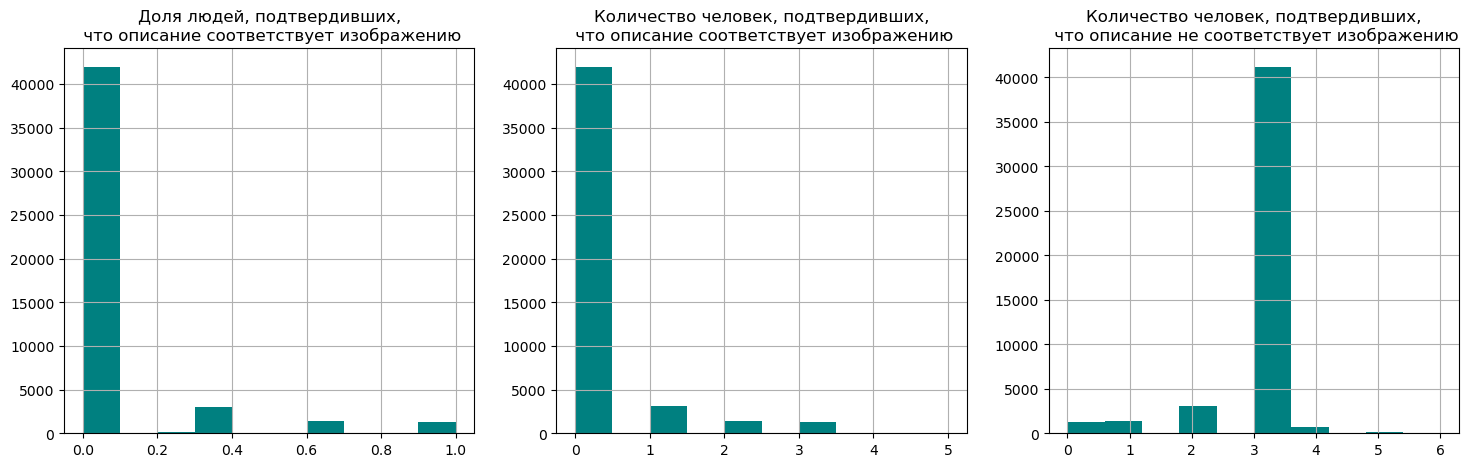

In [7]:
# визуализация данных
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

crowd_annotat['fraction'].hist(ax=axes[0], color='teal')
axes[0].set_title("Доля людей, подтвердивших,\n что описание соответствует изображению")

crowd_annotat['conf_cnt'].hist(ax=axes[1], color='teal')
axes[1].set_title("Количество человек, подтвердивших,\n что описание соответствует изображению")

crowd_annotat['not_conf_cnt'].hist(ax=axes[2], color='teal')
axes[2].set_title("Количество человек, подтвердивших,\n что описание не соответствует изображению")

plt.show()

__Проанализируем общее число респондентов:__

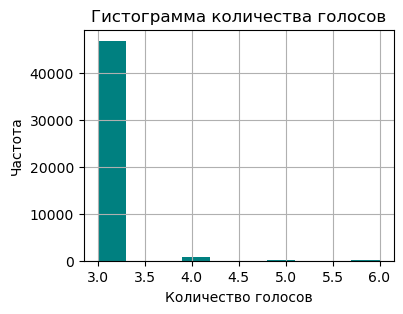

In [8]:
# вычисляем сумму conf_cnt и not_conf_cnt для каждой записи
crowd_annotat['total_votes'] = crowd_annotat['conf_cnt'] + crowd_annotat['not_conf_cnt']

plt.figure(figsize=(4, 3))
crowd_annotat['total_votes'].hist(color='teal')
plt.title("Гистограмма количества голосов")
plt.xlabel("Количество голосов")
plt.ylabel("Частота")
plt.show()

> Низкая доля подтверждений (fraction), это может свидетельствовать о низкой уверенности пользователей в соответствии описания и изображения.
>
>Значительный разброс в числе подтверждений (conf_cnt) и неподтверждений (not_conf_cnt), что может указывать на несогласие между разными пользовательскими оценками.
>
>Высокое количество неподтверждений (not_conf_cnt), что может быть вызвано неправильным описанием или изображением.
>
>Общее число респондентов редко превышает трех человек, это дает основание склоняться к оценке экспертов.

### Числовы признаки датасета expert_annotat

In [9]:
# статистика для expert_annotat
console.print('[bold]Статистика для expert_annotat:[/bold]')
print(expert_annotat.describe())

Статистика для expert_annotat:

             exp_1        exp_2        exp_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000


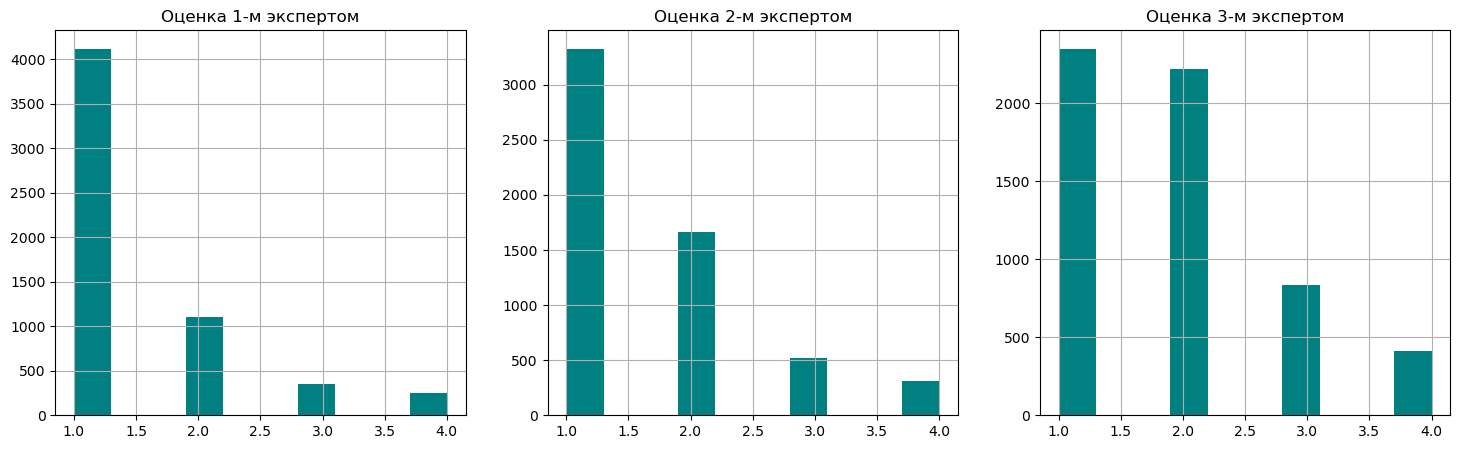

In [10]:
# визуализация данных
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

expert_annotat['exp_1'].hist(ax=axes[0], color='teal')
axes[0].set_title("Оценка 1-м экспертом")

expert_annotat['exp_2'].hist(ax=axes[1], color='teal')
axes[1].set_title("Оценка 2-м экспертом")

expert_annotat['exp_3'].hist(ax=axes[2], color='teal')
axes[2].set_title("Оценка 3-м экспертом")

plt.show()

> Данные от экспертор менее склонны к низким оценкам и имеют меньшую вариабельность. 

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Юридические ограничения

</div>

Поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

Так как в данных отсутсвует информация о возрасте людей на фотографиях, нет прямой возможности очистить от них данные: 
  - выберем фотографии с изображением детей,
  - отсортируем тренировочный датасет по найденным фотографиям,
  - проведем очистку и первичную обработку коментариев,
  - токенизирует и приведем токены к лемме,
  - проведем частотный анализ слов, выделев слова, связанные с детьми и подростками.

In [11]:
# фотографии с изображением детей
csv_url = 'https://raw.githubusercontent.com/Denis-Mukhanov/search-by-images/main/data/child.csv'
child = pd.read_csv(csv_url)
display(child.head(2))

,image
0,3767841911_6678052eb6.jpg
1,106490881_5a2dd9b7bd.jpg


__Выведем на экран несколько фотографий__

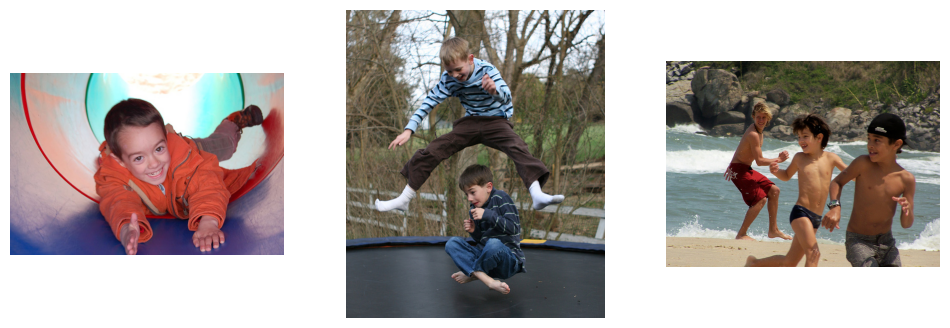

In [12]:
# количество изображений, в выборке
num_images = 3

# выборка
selected_rows = child.sample(n=num_images, random_state=RANDOM_SEED)

# визуализация
fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

for i, (index, row) in enumerate(selected_rows.iterrows()):
    image_filename = row['image']  
    image_path = os.path.join(TRAIN_IMAGES, image_filename)
    
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

__Записи датасета, содержащие изображения детей__

In [13]:
df_child = child.merge(train_df, on='image', how='inner')[['image', 'query_text']]
display(df_child.head(2))

,image,query_text
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .


__Предобработка текста__

In [14]:
# функция для первичной обработки текста
def clean_text(txt):
    txt = txt.lower() # перевод в нижний регист
    txt = re.sub(LETTERS, ' ', txt) #не буквенные символы меняем на пробел
    txt = re.sub(SPACES, r'\1', txt) #повторяющиеся пробелы меняем на один пробел
    return txt

df_child['clean_text'] = df_child['query_text'].apply(clean_text)
display(df_child.head(2))

,image,query_text,clean_text
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .,a dog jumps to catch a red frisbee in the yard
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .,a black and white dog prepares to catch a frisbee


__Удаление стоп-слов__

In [15]:
# загрузка стоп-слов для английского языка
english_stopwords = stopwords.words('english')

# функция для удаления стоп-слов и токенизации текста
def stopwords_tokenize(x):
    tokens = word_tokenize(x)
    tokenization = [word for word in tokens if not word in english_stopwords]
    return ' '.join(tokenization)

df_child['clean_text'] = df_child['clean_text'].apply(stopwords_tokenize)
display(df_child.head(2))

,image,query_text,clean_text
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .,dog jumps catch red frisbee yard
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .,black white dog prepares catch frisbee


__Лемматизация текста__

In [16]:
# экземпляр WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def penn2morphy(penntag):
    # словарь для соответствия тегов Penn Treebank тегам WordNet.
    morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]] # соответствующий тег WordNet
    except:
        return 'n' # (существительное) по умолчанию
    
def lemmatize_text(text): 
    # функция принимает на вход строку текста и выполняет лемматизацию
    # возвращается строку из лемматизированных слов
    return ' '.join(lemmatizer.lemmatize(word, pos=penn2morphy(tag)) for word, tag in pos_tag(word_tokenize(text)))

df_child['clean_text'] = df_child['clean_text'].apply(lemmatize_text)
display(df_child.head(2))

,image,query_text,clean_text
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .,dog jump catch red frisbee yard
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .,black white dog prepares catch frisbee


__Токенизация и частотный анализ текста__

In [17]:
# токенизация текста
df_child['tokens'] = df_child['clean_text'].apply(lambda x: x.split())
display(df_child.head(2))

,image,query_text,clean_text,tokens
0,3767841911_6678052eb6.jpg,A dog jumps to catch a red Frisbee in the yard .,dog jump catch red frisbee yard,"[dog, jump, catch, red, frisbee, yard]"
1,3767841911_6678052eb6.jpg,A black and white dog prepares to catch a Frisbee .,black white dog prepares catch frisbee,"[black, white, dog, prepares, catch, frisbee]"


In [18]:
# список всех токенов
tokens_list = [item for sublist in df_child['tokens'].to_list() for item in sublist]
# частотность токенов
freq_dist = FreqDist(tokens_list)

In [19]:
# перевод частотности в датафрейм
freq_df = pd.DataFrame.from_dict(freq_dist, orient='index', columns=['freq'])
# сортировка
freq_df = freq_df.sort_values(by='freq', ascending=False)
# наиболее частые слова
print(freq_df.index[:100])

Index(['dog', 'man', 'two', 'boy', 'girl', 'woman', 'white', 'child', 'young',
       'wear', 'play', 'little', 'stand', 'blue', 'jump', 'red', 'black',
       'water', 'shirt', 'sit', 'people', 'run', 'smile', 'front', 'walk',
       'beach', 'pool', 'swing', 'hold', 'player', 'ball', 'brown', 'look',
       'camera', 'next', 'person', 'group', 'men', 'snow', 'field', 'hat',
       'green', 'basketball', 'near', 'large', 'one', 'building', 'small',
       'three', 'yellow', 'watch', 'slide', 'grass', 'street', 'rid', 'orange',
       'tree', 'rock', 'pink', 'kid', 'another', 'ocean', 'jacket', 'baby',
       'dress', 'crowd', 'pose', 'dirt', 'bike', 'air', 'mouth', 'uniform',
       'soccer', 'catch', 'face', 'background', 'purple', 'park', 'hand',
       'playground', 'sand', 'adult', 'top', 'take', 'sunglass', 'swim',
       'ride', 'table', 'outside', 'city', 'outdoor', 'toddler', 'around',
       'car', 'beside', 'hair', 'dance', 'football', 'strip', 'toy'],
      dtype='object')


__Список слов, относящихся к детям__

In [20]:
child_list = ['boy', 'girl', 'child', 'young', 'baby', 'teenage', 'kid', 'toddler']

> Определен список слов, отпределяющий изображение детей в наборе данных.

## Удаление записей содержащие в описании слова, относящихся к детям.

In [21]:
# функция по обработке текста
def clean_tokenize_text(text):
    text = clean_text(text)
    text = stopwords_tokenize(text)
    text = lemmatize_text(text)
    return text.split()

# функция для поиска слов, относящихся к детям
def child(x):
    if any(i in x for i in child_list): return 'child'
    return 'not_a_child'

In [22]:
# обработка датасета с данными для тренировки
train_df['tokens'] = train_df['query_text'].apply(clean_tokenize_text)
train_df['child'] = train_df['tokens'].apply(child)
display(train_df.head(2))

,image,query_id,query_text,tokens,child
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .,"[young, child, wear, blue, goggles, sit, float, pool]",child
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitting in a float in a pool .,"[young, child, wear, blue, goggles, sit, float, pool]",child


In [100]:
# исключение записей, относящиеся к детям
train = train_df[train_df['child'] != 'child'][['image', 'query_id', 'query_text']].copy()

In [24]:
print(f'Исключено {len(train_df)-len(train)} записей, относящиеся к детям')

Исключено 1619 записей, относящиеся к детям


> Исключино 1619 пар, из обучающего датасета, которые, исходя из подготовленного списка слов, могут попадать под юридические ограничения.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  Подготовка данных к обучению модели

</div>

## Векторизация текстового описания

(Bidirectional Encoder Representations from Transformers) представляют собой векторные представления слов и текстов, полученные с использованием модели глубокого обучения BERT. Это одна из наиболее мощных и контекстно-зависимых моделей в области обработки естественного языка (NLP). Его уникальность заключается в способности анализировать контексты слов в обоих направлениях в тексте, что позволяет создавать более богатые и семантически точные представления слов.

__Паддинг данных__

In [101]:
tqdm.pandas()

# проверяем доступность MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# инициализация токенизатор, конфигурацию и модель BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')
config = transformers.BertConfig.from_pretrained('bert-large-uncased')
model = transformers.BertModel.from_pretrained('bert-large-uncased', config=config).to(device)
# токенизируем текста
tokenized = train['query_text'].progress_apply(lambda x:
                                           tokenizer.encode(x, max_length=512, 
                                                            truncation=True, add_special_tokens=True)) 

padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)  

attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor).to(device)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████| 4203/4203 [00:00<00:00, 9443.31it/s]


__Эмбеддинги текста__

In [34]:
# создание эмбедингов
batch_size = 467
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.Tensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

text_features = np.concatenate(embeddings)

# сохранение эмбеддингов в файл
np.save('data/text_features.npy', text_features)

  0%|          | 0/9 [00:00<?, ?it/s]

In [26]:
# загрузка эмбеддингов из файла
text_features = np.load('data/text_features.npy')
# дополнение датасета эмбедингами 
train['text_embeddings'] = text_features.tolist()

>Эмбеддинги текста с использованием модели BERT представляют собой мощный инструмент для анализа текстовых данных. BERT учитывает контекст слов и их взаимодействие в предложении, что позволяет получать эмбеддинги, более точно передающие семантику текста.

## Векторизация изображений
Для получения векторов изображений использованием модель ResNet50 из библиотеки PyTorch.

__Загрузка и настройка модели__

In [82]:
weights = ResNet50_Weights.DEFAULT #веса модели
resnet = resnet50(weights=weights).to(device) #загрузка модели

for param in resnet.parameters():
    param.requires_grad_(False) #заморозка весов
    
# оставим только свёрточные слои
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules).to(device) #использует MPS

resnet.eval() #режим предсказания

#центрирование и нормализация изображения
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 

__Векторизацию изображений__

Так как в данных изображения повторяются:
- выделим уникальные изображения, 
- получив векторное представление,
- объединим полученные данные с исходным набором данных.

In [29]:
# список уникальных фотографий
train_images_list = train['image'].unique()

In [133]:
# создание векторов
vektors = []

for image_name in notebook.tqdm(train_images_list):
    image = Image.open(TRAIN_IMAGES+image_name).convert('RGB')
    image = preprocess(image)
    image = Variable(image.unsqueeze(0)).to(device)
    
    vektor = resnet(image).cpu().flatten().numpy() # преобразование в одномерный массив
    vektors.append(vektor)


  0%|          | 0/991 [00:00<?, ?it/s]

In [184]:
images_vektors = np.array(vektors)
# сохранение векторы в файл
np.save('data/images_vektors.npy', images_vektors)

In [30]:
# загрузка векторов из файла
images_vektors = np.load('data/images_vektors.npy')

data = pd.DataFrame({'image': train_images_list, 'image_vector': images_vektors.tolist()})
# объединение векторов изображений с набором данных
train = train.merge(data, on='image', how='left')

In [31]:
display(train.head(1))

,image,query_id,query_text,text_embeddings,image_vector
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[-0.442132830619812, -0.1752360463142395, -0.6462795734405518, -0.07560660690069199, 0.03683622181415558, -0.13354791700839996, -0.24680304527282715, 0.024418000131845474, 1.0290032625198364, 0.20937953889369965, 0.11284472793340683, 0.08600756525993347, -1.0471441745758057, -1.107011079788208, 0.3784726858139038, 0.34661683440208435, 0.09652493894100189, -0.30177849531173706, 0.4375731348991394, -0.6344032883644104, -0.18963715434074402, -0.11867303401231766, -0.9097326397895813, -0.2061103...","[0.688458263874054, 0.014536263421177864, 0.05734941363334656, 1.9562779664993286, 0.0861617848277092, 0.0979248657822609, 0.0, 1.1840816736221313, 0.0, 0.005154959857463837, 0.0102255679666996, 0.09217001497745514, 0.0035987775772809982, 0.02286910079419613, 0.0, 0.1136026531457901, 0.0, 0.0, 0.0, 0.35074734687805176, 0.0, 0.874262273311615, 0.031013060361146927, 0.0, 0.0, 0.0, 1.6644785404205322, 0.0, 0.0, 0.16941383481025696, 0.0, 0.03534914553165436, 0.32875266671180725, 0.00069291738327..."


## Размерности векторов
Проверим размерности насколиких пар векторов. Так как векторы представлены в виде списков нас интересует их длинны

In [187]:
for i in range(2):
    print(f'''
Размерность {i+1}-й пары:
text_embeddings: {len(train.iloc[i][3])}
image_vector: {len(train.iloc[i][4])}
    ''')


Размерность 1-й пары:
text_embeddings: 1024
image_vector: 2048
    

Размерность 2-й пары:
text_embeddings: 1024
image_vector: 2048
    


> Вектора имеют разную длинну, это надо учесть в процессе построения моделей.

__Объединим векторы признаков__

In [32]:
train['concatenated_vector'] = train.apply(lambda row: np.concatenate([row['text_embeddings'],
                                                                             row['image_vector']], axis=None), axis=1)
print(f'Размерность объединенного вертора: {len(train.iloc[0][5])}')

Размерность объединенного вертора: 3072


> Стоит отметить, что при конкатинации векторов, получим вектор длинной 3072, с учетом количества записей(4203), линейные модели вероятнее всего не подойдут для решения данной задачи.

## Оценка экспертов
Дополним дотасет оценкой экспертов:
- рассчитам среднее значение между тремя оценками,
- дополним текущий набор данных оценкой экспертов.

In [33]:
# функция рассчета средней оценки экспертов
def mean_exp(x):
    return np.mean([x['exp_1'], x['exp_2'], x['exp_3']])

expert_annotat['mean_exp'] = expert_annotat.apply(mean_exp, axis=1)

In [34]:
# объединение данных
final_df = train.merge(expert_annotat, on=['image', 'query_id'], how='inner')[['concatenated_vector', 'mean_exp']]

In [35]:
if len(final_df)==len(train):
    print('Оценка экспертов найдена для всех пар')
else: print('Оценка экспертов найдена не для всех пар')

Оценка экспертов найдена для всех пар


> Подготовлены данные для обучения моделей.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  Обучение модели

</div>

__Проведем сравнительный анализ трех моделей, обученных на следующих алгоритмах:__
- LinearRegression
- Нейросеть на основе фреймворка PyTorch

__Метрика качества:__ RMSE

Преимущество RMSE заключается в том, что ее значения имеют ту же размерность, что и исходные данные, что делает ее более интерпретируемой.

In [58]:
# функция для расчета RMSE
def rmse_score(values, predict):
    return sqrt(mean_squared_error(values, predict))

rmse_scorer = make_scorer(rmse_score)

# функция для вывода результатов
def output_results(trial):
    print('Результаты подборы параметров:')
    print('  RMSE:', round(trial.value, 4))
    print('  Params: ')
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


__Выделение обучающей и валидационной выборок__

Разделим данные на обучающую и валидационную выборки. На валидацию выделим 20% от исходных данных.

In [38]:
# разделение данных на признаки (X) и целевую переменную (y)
X = final_df['concatenated_vector'].apply(pd.Series).values  # Разделяем векторы на отдельные признаки
y = final_df['mean_exp']

# Разделение данных на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

##  LinearRegression

</div>

__baseline model__

Проверим линейную модель, на пригодность использования в данной задаче.

In [241]:
# создание и обучение модели LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# прогнозирование на тестовых данных
y_pred = model.predict(X_valid)

# оценка модели
print(f'RMSE: {rmse_score(y_valid, y_pred)}')

RMSE: 981888180006.8752


> Как и предпологалось, при обучении линейной модели дает неадекватные резулитьты на валидационных данных. Возможные причины:
> - Линейность данных: Линейная регрессия предполагает линейную зависимость между признаками и целевой переменной. Если зависимость нелинейная, то линейная модель может быть неспособной описать данные.
> - Недостаточное количество данных: Если данных недостаточно для обучения модели, то линейная регрессия может не иметь достаточной информации для выработки хороших прогнозов.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

##  Нейросеть PyTorch

</div>

### Подготовка данных

In [40]:
# преобразование выборок в тензоры и корректировка типа данных
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_np = np.array(y_valid, dtype=np.float32)# преобразование Series в массив NumPy
y_valid_tensor = torch.tensor(y_valid_np, dtype=torch.float32)

# проверка размерности и типа данных тензоров
for x in ['X_train_tensor', 'X_valid_tensor', 'y_train_tensor', 'y_valid_tensor']:
    print(f'Размерность {x}: {globals()[x].shape} - {globals()[x].dtype}')

Размерность X_train_tensor: torch.Size([3362, 3072]) - torch.float32
Размерность X_valid_tensor: torch.Size([841, 3072]) - torch.float32
Размерность y_train_tensor: torch.Size([3362]) - torch.float32
Размерность y_valid_tensor: torch.Size([841]) - torch.float32


>Для создания пакетов (batch) используем Dataloader, предоставляющий удобный способ загрузки и предварительной обработки данных во время обучения моделей машинного обучения. Данный компонент PyTorch позволяет настраивать различные параметры для загрузки данных, такие как размер пакета (batch size), количество рабочих процессов для параллельной загрузки данных (num_workers)

In [41]:
# класс для создания пакетов
class Batch(Dataset):
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.data[idx]
        sample = {'data': data, 'mean_exp': label}
        return sample

In [42]:
dataset_train = Batch(X_train_tensor, y_train_tensor)
dataset_test = Batch(X_valid_tensor, y_valid_tensor)

### Архитектура нейронной сети
__Архитектура нейронной сети:__

1 Входной слой:

   - Размерность входных данных определяется переменной input_size и равен количеству признаков.
   - Этот слой представлен в виде линейного слоя (nn.Linear), который принимает входные данные и производит линейную трансформацию с помощью весов и смещения.
   
2 Скрытые слои:

   - В данной архитектуре нейронной сети используем четыре скрытых слоя.
   - Каждый скрытый слой состоит из линейного слоя (nn.Linear), за которым следует функция активации.
   - Функции активации, используемые в этой архитектуре, определяются переменными activation_1, activation_2, activation_3, activation_4.
   - Добавление техники регуляризации Dropout, поможет улучшить обобщающую способность нейронной сети и снизит риск переобучения, вероятности выключения нейронов в слоях определяются переменными drop_1, drop_2, drop_3, drop_4. В baseline-модели данную технику применим только к первому слою, затем подберем опримальные параметры для этого и остальных слоев.
   - Размеры скрытого слоя определяются переменными hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4.
   
3 Выходной слой:

   - Выходной слой представлен линейным слоем (nn.Linear), который преобразует выходные значения скрытых слоев в одно число.
   - В данном случае, поскольку решается задача регрессии, выходной слой имеет размерность 1 и задается переменной output_size.
   
4 Инициализация весов:
   - Инициализацию весов будем производить с помощью метода Kaiming, что может помочь ускорить процесс обучения и предотвратить затухания/взрыва градиента.
   
5 Функция потерь:

   - Функция потерь будет определена переменной loss и учитывая задачу используем nn.MSELoss()

In [43]:
# определение архитектуры нейронной сети
class Baseline(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4):
        super(Baseline, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.act1 = activation_1
        self.drop1 = nn.Dropout(drop_1)
        
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = activation_2
        self.drop2 = nn.Dropout(drop_2)
        
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.act3 = activation_3
        self.drop3 = nn.Dropout(drop_3)
        
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.act4 = activation_4
        self.drop4 = nn.Dropout(drop_4)
        
        self.fc5 = nn.Linear(hidden_size_4, output_size)
        
        self.init_weights()
        
    def forward(self, x):
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.drop3(self.act3(self.fc3(x)))
        x = self.drop4(self.act4(self.fc4(x)))
        x = self.fc5(x)
        return x
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

__Ранняя остановка__

Чтобы не подбирать коливо эпох и при этом избежать переобучения, воспользуемся ранней остановкой, для этого напишем класс для ее реализации.

In [44]:
class CustomEarlyStopping():
    """
    Ранняя остановка: остановить тренировку, если функция потерь не улучшается после определенного количества эпох.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться
        :param min_delta: минимальная разница функций потерь для активации param patience
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:  # обновление значения функция потерь при улучшении
            self.best_loss = val_loss 
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:  # счетчик patience при ухудшении функция потерь
            self.counter += 1
            if self.counter >= self.patience:
                print(f'INFO: Ранняя остановка. Счетчик: {self.counter}/{self.patience}')
                self.early_stop = True  # остановка обучения при достижении максимума счетсика patience

__Функция для обучения__

In [45]:
def train(model, train_dataloader, test_dataloader, optimizer, loss, n_epochs, patience, min_delta):
    
    result = {'rmse_train': [],
             'rmse_test': [],
             'best_epoch': None,
             'stopping_epoch': None,
             'best_model': None}
    
    early_stopping = CustomEarlyStopping(patience, min_delta)
    for epoch in range(n_epochs):
        # обучение
        model.train()
        total_loss = 0.0
        for batch in train_dataloader:
            data = batch['data']
            label_train = batch['mean_exp']
            
            optimizer.zero_grad()
            
            predictions = model.forward(data).flatten()
            loss_value = loss(predictions, label_train)
            total_loss += loss_value.item()
            
            loss_value.backward()
            optimizer.step()
            
        rmse_tr = sqrt(total_loss/len(train_dataloader))
        result['rmse_train'].append(rmse_tr)
        
        # тестирование
        model.eval()
        total_loss = 0.0
        with torch.no_grad(): # отключаем вычисление градиентов
            for batch in test_dataloader:
                data = batch['data']
                label_test = batch['mean_exp']
                
                predictions = model.forward(data).flatten()
                loss_value = loss(predictions, label_test)
                total_loss += loss_value
            rmse_ts = sqrt(total_loss/len(test_dataloader))
            result['rmse_test'].append(rmse_ts)
            
        if epoch % 10 == 0 or epoch == n_epochs - 1:    
             print(f'Epoch: {epoch} RMSE_train: {round(rmse_tr, 4)} RMSE_test: {round(rmse_ts, 4)}')
        
        early_stopping(rmse_ts)
        if early_stopping.counter == 1:
            result['best_model'] = model
        if early_stopping.early_stop:
            result['best_epoch'] = epoch-patience
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch-patience} RMSE_train: {round(result['rmse_train'][-patience], 4)} RMSE_test: {round(result['rmse_test'][-patience], 4)}")
            break
        if epoch == n_epochs-1:
            result['best_epoch'] = epoch
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch} RMSE_train: {round(result['rmse_train'][-1], 4)} RMSE_test: {round(result['rmse_test'][-1], 4)}")        
    return result

In [299]:
# параметры Baseline нейронной сети

# размер слоев
input_size = X_train_tensor.shape[1]  
hidden_size_1 = 1024  
hidden_size_2 = 512  
hidden_size_3 = 256 
hidden_size_4 = 128 
output_size = 1 
# функции активации
activation_1 = nn.ReLU()
activation_2 = nn.Tanh()
activation_3 = nn.ReLU()
activation_4 = nn.LeakyReLU()
# вероятности выключения нейроны в слое
drop_1 = 0.1
drop_2 = 0.0
drop_3 = 0.0
drop_4 = 0.0

learning_rate = 0.01  # скорость обучения
n_epochs = 1000  # количество эпох обучения
batch_size = 32  # размер пакета

In [300]:
# экземпляр нейронной сети
model = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4)
# функция потерь
loss = nn.MSELoss()
# оптимизатор
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# пакеты (batch)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

### Обучение baseline-модели

In [273]:
# обучение и сохранение результатов
result = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss=loss,
               n_epochs=n_epochs,
               patience=20,
               min_delta=0)

Epoch: 0 RMSE_train: 0.9667 RMSE_test: 1.0795
Epoch: 10 RMSE_train: 0.8497 RMSE_test: 0.8506
Epoch: 20 RMSE_train: 0.8431 RMSE_test: 0.8493
INFO: Ранняя остановка. Счетчик: 20/20
Best epoch: 8 RMSE_train: 0.8477 RMSE_test: 0.8507


__График процесса обучения__

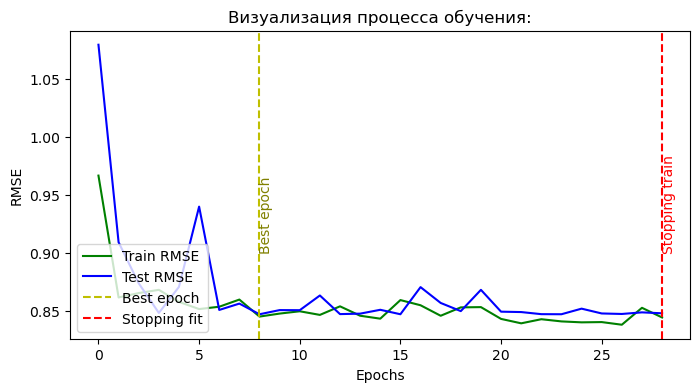

In [274]:
plt.figure(figsize=(8, 4))
plt.plot(result['rmse_train'], color='green', label='Train RMSE')
plt.plot(result['rmse_test'], color='blue', label='Test RMSE')

# отметка Best epoch
plt.axvline(x=result['best_epoch'], color='y', linestyle='--', label='Best epoch')
plt.text(result['best_epoch'], 0.9, 'Best epoch', color='olive', rotation=90, va='bottom')
# отметка Stopping train
plt.axvline(x=result['stopping_epoch'], color='red', linestyle='--', label='Stopping fit')
plt.text(result['stopping_epoch'], 0.9, 'Stopping train', color='red', rotation=90, va='bottom')

plt.title('Визуализация процесса обучения:')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(loc='lower left')
plt.show()

### Улучшение нейронной сети

In [52]:
def objective(trial):

    # dropout
    drop_1 = trial.suggest_float('module__drop_1', 0.0, 0.4, step=0.2)
    drop_2 = trial.suggest_float('module__drop_2', 0.0, 0.4, step=0.2)
    drop_3 = trial.suggest_float('module__drop_3', 0.0, 0.4, step=0.2)
    drop_4 = trial.suggest_float('module__drop_4', 0.0, 0.4, step=0.2)

    # функции активации
    activation_dict = {'nn.LeakyReLU()': nn.LeakyReLU(),
                       'nn.ReLU()': nn.ReLU(),
                       'nn.Tanh()': nn.Tanh(),
                       'nn.ELU()': nn.ELU()
                      }

    activation_1 = trial.suggest_categorical('module__activation_1', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_2 = trial.suggest_categorical('module__activation_2', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_3 = trial.suggest_categorical('module__activation_3', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])
    activation_4 = trial.suggest_categorical('module__activation_4', ['nn.LeakyReLU()', 'nn.ReLU()', 'nn.Tanh()', 'nn.ELU()'])

    activation_1 = activation_dict.get(activation_1)
    activation_2 = activation_dict.get(activation_2)
    activation_3 = activation_dict.get(activation_3)
    activation_4 = activation_dict.get(activation_4)


    # количество нейронов
    input_size = X_train_tensor.shape[1] 
    output_size = 1

    hidden_size_1 = trial.suggest_int('module__hidden_size_1', 128, 2048,  step=128)
    hidden_size_2 = trial.suggest_int('module__hidden_size_2', 64, 1024,  step=64)
    hidden_size_3 = trial.suggest_int('module__hidden_size_3', 32, 512,  step=32)
    hidden_size_4 = trial.suggest_int('module__hidden_size_4', 16, 240,  step=16)



    # скорость обучения
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-0, log=True)
    
    # размер пакета обучения
    batch_size = trial.suggest_int('batch_size', 32, 512,  step=32)
    
    # модель
    model_base = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                          drop_1, drop_2, drop_3, drop_4,
                          activation_1, activation_2, activation_3, activation_4)
    
    # количество шагов до остановки обучения
    patience = trial.suggest_int('patience', 10, 40,  step=10)

    # параметры подбора параметров модели
    skorch_regressor = NeuralNetRegressor(module=model_base,
                                      device='mps',
                                      verbose=0,
                                      batch_size=batch_size,
                                      optimizer=torch.optim.Adam,
                                      max_epochs=1000,
                                      lr=lr,
                                      criterion = nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE', patience=patience))
            ]
                                     )



    rmse = cross_val_score(skorch_regressor, X_train_tensor.numpy(),
                            y_train_tensor.numpy().reshape(-1, 1),
                            n_jobs=-1,
                            cv=4,
                            scoring=rmse_scorer)
    rmse = rmse.mean()
    return rmse

In [54]:
# Создайте экземпляр study
study = optuna.create_study(direction='minimize')

# Укажите количество итераций
n_trials = 100

# Создайте прогресс бар с использованием tqdm
for _ in tqdm(range(n_trials), desc="Optimizing", ncols=100):
    study.optimize(objective, n_trials=1)

[I 2023-10-06 15:02:03,466] A new study created in memory with name: no-name-b29e89bd-1788-4e30-a0df-fa781d48984f
Optimizing:  11%|█████▌                                            | 11/100 [03:21<50:21, 33.95s/it][I 2023-10-06 15:05:42,249] Trial 11 finished with value: 0.7813237757937378 and parameters: {'module__drop_1': 0.4, 'module__drop_2': 0.0, 'module__drop_3': 0.4, 'module__drop_4': 0.4, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.ReLU()', 'module__hidden_size_1': 1152, 'module__hidden_size_2': 448, 'module__hidden_size_3': 32, 'module__hidden_size_4': 176, 'learning_rate': 1.778180208876346e-05, 'batch_size': 64, 'patience': 10}. Best is trial 5 with value: 0.7548680879081918.


Optimizing:  23%|███████████                                     | 23/100 [17:17<1:53:12, 88.22s/it][I 2023-10-06 15:20:16,165] Trial 23 finished with value: 0.7504621289319422 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.2, 'module__drop_3': 0.0, 'module__drop_4': 0.4, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.ELU()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.ReLU()', 'module__hidden_size_1': 1792, 'module__hidden_size_2': 960, 'module__hidden_size_3': 160, 'module__hidden_size_4': 96, 'learning_rate': 4.04961714162197e-06, 'batch_size': 224, 'patience': 40}. Best is trial 23 with value: 0.7504621289319422.


Optimizing:  35%|█████████████████▌                                | 35/100 [25:07<44:04, 40.69s/it][I 2023-10-06 15:27:34,295] Trial 35 finished with value: 0.7662071610998845 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.2, 'module__drop_3': 0.4, 'module__drop_4': 0.4, 'module__activation_1': 'nn.ReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 1280, 'module__hidden_size_2': 960, 'module__hidden_size_3': 192, 'module__hidden_size_4': 16, 'learning_rate': 1.492083937858573e-05, 'batch_size': 480, 'patience': 30}. Best is trial 32 with value: 0.7483337291061545.


Optimizing:  47%|███████████████████████▌                          | 47/100 [33:15<42:24, 48.01s/it][I 2023-10-06 15:35:29,641] Trial 47 finished with value: 0.7708246494346707 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.2, 'module__drop_3': 0.0, 'module__drop_4': 0.4, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.ReLU()', 'module__hidden_size_1': 1024, 'module__hidden_size_2': 640, 'module__hidden_size_3': 32, 'module__hidden_size_4': 64, 'learning_rate': 3.327050967057838e-05, 'batch_size': 416, 'patience': 30}. Best is trial 32 with value: 0.7483337291061545.


Optimizing:  59%|█████████████████████████████▌                    | 59/100 [51:48<58:23, 85.44s/it][I 2023-10-06 15:54:10,165] Trial 59 finished with value: 0.7565622532205099 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.2, 'module__drop_3': 0.4, 'module__drop_4': 0.4, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.ELU()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 512, 'module__hidden_size_2': 1024, 'module__hidden_size_3': 160, 'module__hidden_size_4': 160, 'learning_rate': 5.906440506759973e-06, 'batch_size': 384, 'patience': 40}. Best is trial 32 with value: 0.7483337291061545.


Optimizing:  71%|███████████████████████████████████▌              | 71/100 [57:59<08:59, 18.60s/it][I 2023-10-06 16:01:38,315] Trial 71 finished with value: 0.763655957775283 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.2, 'module__drop_3': 0.4, 'module__drop_4': 0.4, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.ELU()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.ReLU()', 'module__hidden_size_1': 1152, 'module__hidden_size_2': 320, 'module__hidden_size_3': 128, 'module__hidden_size_4': 80, 'learning_rate': 1.3906075221609505e-06, 'batch_size': 512, 'patience': 40}. Best is trial 32 with value: 0.7483337291061545.


Optimizing:  83%|███████████████████████████████████████▊        | 83/100 [1:10:10<09:30, 33.57s/it][I 2023-10-06 16:12:29,201] Trial 83 finished with value: 0.7514584656182597 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.2, 'module__drop_3': 0.2, 'module__drop_4': 0.4, 'module__activation_1': 'nn.ReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 1664, 'module__hidden_size_2': 1024, 'module__hidden_size_3': 352, 'module__hidden_size_4': 80, 'learning_rate': 2.665758389951127e-05, 'batch_size': 448, 'patience': 30}. Best is trial 77 with value: 0.7451458594373633.


Optimizing:  95%|█████████████████████████████████████████████▌  | 95/100 [1:13:59<01:38, 19.66s/it][I 2023-10-06 16:16:14,247] Trial 95 finished with value: 0.7608460074530694 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.2, 'module__drop_3': 0.2, 'module__drop_4': 0.4, 'module__activation_1': 'nn.ReLU()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 1536, 'module__hidden_size_2': 960, 'module__hidden_size_3': 320, 'module__hidden_size_4': 48, 'learning_rate': 5.018815593161986e-05, 'batch_size': 448, 'patience': 30}. Best is trial 86 with value: 0.7438765845085944.


Optimizing: 100%|███████████████████████████████████████████████| 100/100 [1:15:22<00:00, 45.22s/it]


In [59]:
# вывод результатов 
trial = study.best_trial
output_results(trial)

Результаты подборы параметров:
  RMSE: 0.7439
  Params: 
    module__drop_1: 0.0
    module__drop_2: 0.2
    module__drop_3: 0.2
    module__drop_4: 0.4
    module__activation_1: nn.ReLU()
    module__activation_2: nn.Tanh()
    module__activation_3: nn.ELU()
    module__activation_4: nn.LeakyReLU()
    module__hidden_size_1: 1664
    module__hidden_size_2: 1024
    module__hidden_size_3: 288
    module__hidden_size_4: 64
    learning_rate: 1.1249230636566784e-05
    batch_size: 448
    patience: 30


__Сводная таблица метрик__

In [61]:
data = {
    'Model': ['PyTorch-Baseline', 'PyTorch-Optuna'],
    'RMSE': [0.8507, 0.7439]
    
}
display(pd.DataFrame(data))

,Model,RMSE
0,PyTorch-Baseline,0.8507
1,PyTorch-Optuna,0.7439


> Как видно использование Optuna облегчает и ускоряет процесс подбора гиперпараметров благодаря автоматизации, эффективным алгоритмам оптимизации, интеграции, возможности многокритериальной оптимизации и поддержке распределенных вычислений, что делает его мощным инструментом для улучшения производительности моделей машинного обучения.

### Обучение модели с лучшими гиперпараметрами

In [62]:
# инициализация оптимальных параметров
best_params = study.best_params
# инициализация оптимальных параметров
activation_dict = {'nn.LeakyReLU()': nn.LeakyReLU(),
                       'nn.ReLU()': nn.ReLU(),
                       'nn.Tanh()': nn.Tanh(),
                       'nn.ELU()': nn.ELU()
                      }

input_size = X_train.shape[-1]
output_size = 1

hidden_size_1 = best_params['module__hidden_size_1']
hidden_size_2 = best_params['module__hidden_size_2']
hidden_size_3 = best_params['module__hidden_size_3']
hidden_size_4 = best_params['module__hidden_size_4']

drop_1 = round(best_params['module__drop_1'], 1)
drop_2 = round(best_params['module__drop_2'], 1)
drop_3 = round(best_params['module__drop_3'], 1)
drop_4 = round(best_params['module__drop_4'], 1)

activation_1 = best_params['module__activation_1']
activation_2 = best_params['module__activation_2']
activation_3 = best_params['module__activation_3']
activation_4 = best_params['module__activation_4']

activation_1 = activation_dict.get(activation_1)
activation_2 = activation_dict.get(activation_2)
activation_3 = activation_dict.get(activation_3)
activation_4 = activation_dict.get(activation_4)

learning_rate = best_params['learning_rate']

batch_size = best_params['batch_size']

patience = best_params['patience']

best_model = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                          drop_1, drop_2, drop_3, drop_4,
                          activation_1, activation_2, activation_3, activation_4)

best_regressor = NeuralNetRegressor(module=best_model, device='mps', verbose=0,
                                           batch_size=best_params['batch_size'], optimizer=torch.optim.Adam,
                                           max_epochs=2500, lr=best_params['learning_rate'], criterion=nn.MSELoss,
                                           callbacks=[('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                                                      ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE', patience=best_params['patience']))])

best_regressor.fit(X_train_tensor, y_train_tensor.reshape(-1,1))

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Baseline(
    (fc1): Linear(in_features=3072, out_features=1664, bias=True)
    (act1): ReLU()
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=1664, out_features=1024, bias=True)
    (act2): Tanh()
    (drop2): Dropout(p=0.2, inplace=False)
    (fc3): Linear(in_features=1024, out_features=288, bias=True)
    (act3): ELU(alpha=1.0)
    (drop3): Dropout(p=0.2, inplace=False)
    (fc4): Linear(in_features=288, out_features=64, bias=True)
    (act4): LeakyReLU(negative_slope=0.01)
    (drop4): Dropout(p=0.4, inplace=False)
    (fc5): Linear(in_features=64, out_features=1, bias=True)
  ),
)

#### Прогнозирование на валидационных данных

In [63]:
# вычисление RMSE на валидационных данных
y_pred_valid = best_regressor.predict(X_valid_tensor)

print(f"RMSE на валидационных данных: {rmse_score(y_valid, y_pred_valid):.4f}")

RMSE на валидационных данных: 0.7057


> Полученное значение RMSE на валидационных данных (0.7057) указывает на то, что ваша обученная модель демонстрирует хорошую производительность в прогнозировании целевой переменной на новых данных. Более низкое значение RMSE свидетельствует о более точных прогнозах модели.

### Финальная модель, обученная на всех данных

In [66]:
# обучающие и валидационные данные
X_combined = torch.cat((X_train_tensor, X_valid_tensor), dim=0)
y_combined = torch.cat((y_train_tensor.reshape(-1, 1), y_valid_tensor.reshape(-1, 1)), dim=0)

# модель обученная на всех данных
best_regressor.fit(X_combined, y_combined)

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Baseline(
    (fc1): Linear(in_features=3072, out_features=1664, bias=True)
    (act1): ReLU()
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=1664, out_features=1024, bias=True)
    (act2): Tanh()
    (drop2): Dropout(p=0.2, inplace=False)
    (fc3): Linear(in_features=1024, out_features=288, bias=True)
    (act3): ELU(alpha=1.0)
    (drop3): Dropout(p=0.2, inplace=False)
    (fc4): Linear(in_features=288, out_features=64, bias=True)
    (act4): LeakyReLU(negative_slope=0.01)
    (drop4): Dropout(p=0.4, inplace=False)
    (fc5): Linear(in_features=64, out_features=1, bias=True)
  ),
)

>После обучения и подбора гиперпараметров с использованием библиотеки Optuna, мы получили улучшенную модель, которая продемонстрировала значительное снижение RMSE (Root Mean Square Error) на валидационных данных по сравнению с базовой моделью. Базовая модель имела RMSE равное 0.8507, в то время как улучшенная модель, оптимизированная с помощью Optuna, достигла RMSE в 0.7439. Это улучшение говорит о том, что оптимизация гиперпараметров с помощью Optuna успешно повысила производительность модели.
>
>Теперь у нас есть обученная и оптимизированная модель, которую можно использовать для прогнозирования целевой переменной на новых данных.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Тестирование модели и демонстрация ее работы

</div>

## Векторизация тестовых изображений

In [86]:
# список тестовых изображений
test_images_list = test_df['image'].unique()

In [87]:
# создание векторов
test_vektors = []

for image_name in notebook.tqdm(test_images_list):
    image = Image.open(TEST_IMAGES+image_name).convert('RGB')
    image = preprocess(image)
    image = Variable(image.unsqueeze(0)).to(device)
    
    vektor = resnet(image).cpu().flatten().numpy() # преобразование в одномерный массив
    test_vektors.append(vektor)

  0%|          | 0/100 [00:00<?, ?it/s]

In [88]:
images_test_vektors = np.array(test_vektors)
# сохранение векторы в файл
np.save('data/images_test_vektors', images_test_vektors)

In [89]:
# загрузка векторов из файла
images_test_vektors = np.load('data/images_test_vektors.npy')

test = pd.DataFrame({'image': test_images_list, 'image_vector': images_test_vektors.tolist()})

## Функция для тестирования

Функция принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.

In [207]:
# функция для эмбеддинга текста
def get_text_embedding(input_text):
    # токенизируем текст
    tokenized = tokenizer.encode(input_text, max_length=512, truncation=True, add_special_tokens=True)
    padded = pad_sequence([torch.as_tensor(tokenized)], batch_first=True)

    # маска внимания
    attention_mask = padded > 0
    attention_mask = attention_mask.type(torch.LongTensor).to(device)

    # эмбеддинги
    with torch.no_grad():
        text_embedding = model(padded.to(device), attention_mask=attention_mask)[0][:, 0, :].cpu().numpy()
    return text_embedding[0].tolist()

# функция для тестирования
def imag_test(query_text):
    text = clean_tokenize_text(query_text)
    if any(i in text for i in child_list): return 'disk.jpeg'
    else:
        text_embedding = get_text_embedding(query_text)
        test['vector'] = test['image_vector'].apply(lambda x: text_embedding+x)
        # преобразование списков в числовой формат с использованием numpy
        test['vector'] = test['vector'].apply(lambda x: np.array(x, dtype=np.float32))
        # создание тензора
        test_vectors = np.stack(test['vector'].to_numpy())
        X_test_tensor = torch.tensor(test_vectors, dtype=torch.float32)
        # вычислите предсказания
        test['pred'] = best_regressor.predict(X_test_tensor)
        # получение максимально близкого изображения
        return test[test['pred'] == test['pred'].max()]['image'].values[0]

# функция для вывода изображения по запросу
def display_image_with_caption(query_text):
    image_path = imag_test(query_text)
    fig, ax = plt.subplots(figsize=(6, 6))
    image_path = TEST_IMAGES+image_path
    img = Image.open(image_path)
    ax.imshow(img)
    ax.set_title(query_text, fontsize=12)
    ax.axis('off')
    plt.show()

## Запросы для тестирования

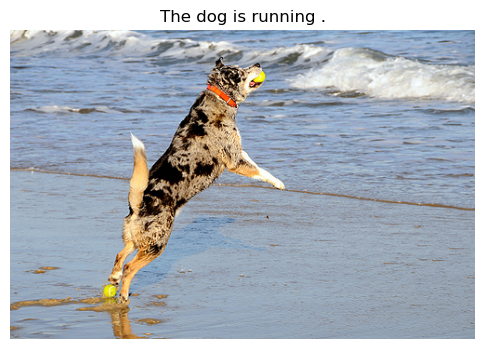

In [209]:
display_image_with_caption('The dog is running .')

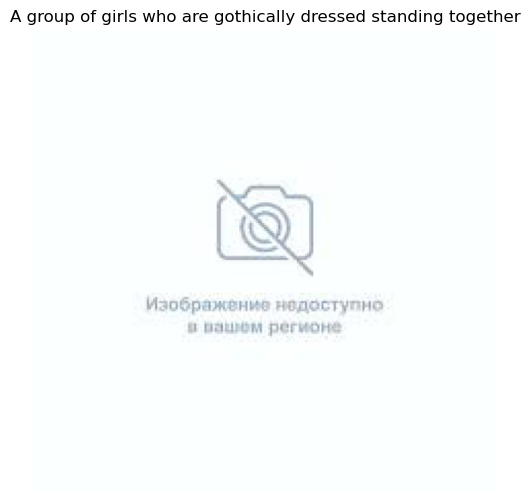

In [208]:
display_image_with_caption('A group of girls who are gothically dressed standing together')

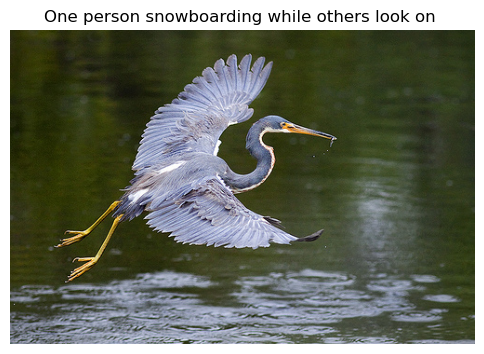

In [220]:
display_image_with_caption('One person snowboarding while others look on ')

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Вывод
    
</div>

В рамках данного проекта была разработана и оптимизирована модель для сочетания изображений и текстовых описаний с целью поиска изображений по текстовым запросам. Несмотря на успешные результаты, важно отметить, что модель не является идеальной, выдавая некорректные изображения при запросе и существуют пути для ее дальнейшего улучшения. Тем не менее, проект практически осуществим, и это можно продемонстрировать на практике.

Практическая реализация поиска изображений по текстовым запросам может иметь широкое применение, например, в веб-поиске, электронной коммерции и многих других областях. Этот проект может служить основой для дальнейшего развития и оптимизации системы.

Пути дальнейшего улучшения модели включают в себя:

- Использование более сложных архитектур: Рассмотреть более сложные архитектуры нейронных сетей, такие как Transformer-based модели или гибридные модели, способные более точно ассоциировать текстовые запросы с изображениями.

- Использование больших объемов данных: Увеличить объем обучающих данных для улучшения обобщающей способности модели.

Эти шаги позволят создать более точную и мощную систему поиска изображений по текстовым запросам и повысить ее практическую ценность для различных областей применения.